# Import Libraries

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import time
import datetime
import math


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


import warnings
warnings.filterwarnings('ignore')

---

# In processing and modelling, we took 2 approaches:
1. Using non-text features
2. Using text features

Here, we will first look at non-text features

___

# 1. Preprocessing

### Import cleaned data from Project 3b 

In [23]:
df_combined = pd.read_csv("../data/df_for_modelling_top2500.csv")
# delete unwanted columns
df_combined = df_combined.drop(columns='Unnamed: 0')

**We take the top 2500 posts in each category and proceed with some pre-processing**
- first we convert `created_utc` column into `day` and `hour` columns
- then we OneHotEncode the above 2 columns as well as the target variable `subreddit` column

In [24]:
# converting and splitting the created_utc column into its
# respective day, hour columns
df_combined['created_utc'] = df_combined['created_utc'].map(lambda x:
                                                    datetime.datetime.fromtimestamp(x))

df_combined['day'] =  df_combined['created_utc'].dt.day
df_combined['hour'] =  df_combined['created_utc'].dt.hour

# dropping columns that are not required
df_combined = df_combined.drop(columns=['created_utc','title'])

# converting the target variable subreddit column into 1 and 0, where
# 1 indicates that the post is from r/news and 
# 0 indicates that the post is from r/TheOnion
df_combined.reset_index(drop=True, inplace=True)
df_combined['subreddit'].replace({'news':1,'TheOnion': 0}, inplace=True)

# shifting the target variable subreddit column to the last column 
temp = df_combined['subreddit']
df_combined = pd.concat((df_combined.drop(columns='subreddit'),temp),axis=1)

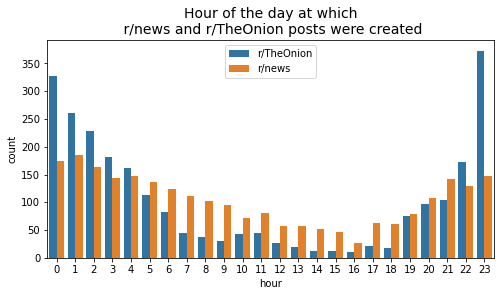

In [25]:
# plotting to see the differences in hour of day when r/news and r/TheOnion posts are posted
plt.figure(figsize=(8,4))
sns.countplot(x='hour', data=df_combined, hue='subreddit');
plt.title("Hour of the day at which\n r/news and r/TheOnion posts were created", fontsize=14);
plt.legend(["r/TheOnion","r/news"]);

Interestingly, we see that r/news posts are created more consistently throughout the day. r/TheOnion posts are more erratic, mostly created at night till the wee hours between 8pm to 2am.
- between 10pm-4am, more r/TheOnion posts were created.
- between 5am-9pm, more r/news posts were created.

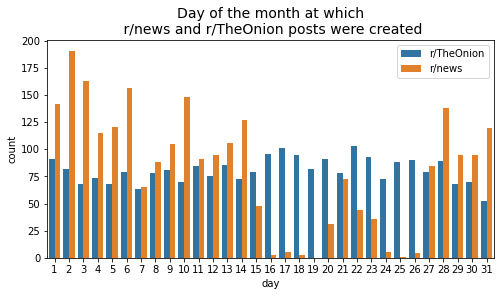

In [26]:
# plotting to see the differences in day of the month when r/news and r/TheOnion posts are posted
plt.figure(figsize=(8,4))
sns.countplot(x='day', data=df_combined, hue='subreddit');
plt.title("Day of the month at which\n r/news and r/TheOnion posts were created", fontsize=14);
plt.legend(["r/TheOnion","r/news"]);

Again, there seems to be a pattern on which day of the month r/news and r/TheOnion posts are created. 
In this case, r/TheOnion posts seems to be created more consitently throughout the month, as compared to r/news, where the posts are mostly created in the early and late part of the month.

These strong correlation gives us confidence that these features will be able to predict well.

**Dummify categorical variables**

In [27]:
df_combined = df_combined.astype({'day':'object', 'hour':'object'})
df_combined = pd.get_dummies(df_combined, columns=['day','hour'])

# shifting the target variable subreddit column to the last column 
temp = df_combined['subreddit']
df_combined = pd.concat((df_combined.drop(columns='subreddit'),temp),axis=1)
df_combined.head()

,num_comments,score,num_char,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,subreddit
0,9093,67198,49,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,17764,54117,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,4675,51147,63,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,5910,45088,122,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,5004,21237,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


___

# 2. Modeling
- Noting that the numerical values for the different features are not of the same scale, we have to scale these values first, in order to give each feature a better reflection of how much it affects the target variable.
- Since Naive Bayes only accepts positive values, we use both MinMaxScaler and StandardScaler to determine which is better for each model.

## 2a. Modeling - Logistic Regression
- StandardScaler was shown to achieve higher score with Logistic Regression, hence we use StandardScaler.

In [28]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df_combined.drop(columns='subreddit'),
                                                   df_combined['subreddit'], test_size=0.2,
                                                   random_state=24)
# apply MinMaxScaler/StandardScaler
ss = StandardScaler()
# ss = MinMaxScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# X_train_sc = X_train
# X_test_sc = X_test

print(X_train_sc.shape)
print(y_train.shape)

(4000, 58)
(4000,)


In [29]:
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train_sc, y_train)
y_pred = LogReg.predict(X_test_sc)
print(LogReg.score(X_train_sc, y_train))
print(LogReg.score(X_test_sc, y_test))

0.8665
0.848


#### GridSearchCV for hyperparameter tuning

In [30]:
from sklearn.model_selection import GridSearchCV
# use GridSearchCV to find the hyperparameters that gives the best modelling scores 
LogReg = LogisticRegression()
LogReg = GridSearchCV(estimator=LogReg, param_grid={'C': [1,10,20], 'solver':['newton-cg','liblinear','lbfgs'],
                      'l1_ratio':[0.25,0.5,0.75]}, verbose = 1, cv =5, return_train_score = False, n_jobs=-1)

# fit scaled train data into the Logistic Regression GridSearch model 
LogReg.fit(X_train_sc, y_train)
LogReg.cv_results_
df = pd.DataFrame(LogReg.cv_results_)
df = df[['mean_test_score','param_solver','param_l1_ratio','param_C']]
LogReg.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'C': 20, 'l1_ratio': 0.25, 'solver': 'newton-cg'}

In [31]:
# apply the best hyperparameters which we got from GridSearch above into our model.
LogReg_GridSearch = LogisticRegression(C= 20, l1_ratio= 0.25, solver= 'newton-cg')
LogReg_GridSearch.fit(X_train_sc, y_train)
y_pred = LogReg_GridSearch.predict(X_test_sc)
print(LogReg_GridSearch.score(X_train_sc, y_train))
print(LogReg_GridSearch.score(X_test_sc, y_test))

0.92175
0.915


In [32]:
train_f1 = f1_score(y_train,LogReg_GridSearch.predict(X_train_sc))
train_acc = accuracy_score(y_train,LogReg_GridSearch.predict(X_train_sc))
train_prec = precision_score(y_train,LogReg_GridSearch.predict(X_train_sc))
train_rec =recall_score(y_train,LogReg_GridSearch.predict(X_train_sc))

test_f1 = f1_score(y_test,y_pred)
test_acc  = accuracy_score(y_test,y_pred)
test_prec = precision_score(y_test,y_pred)
test_rec  = recall_score(y_test,y_pred)


df_results = pd.DataFrame(
                columns = ["F1 score", "Accuracy score", "Precision score", "Recall score"],
                index = ['train', 'test']
)

df_results.loc['train'] = [train_f1, train_acc, train_prec,train_rec]
df_results.loc['test'] = [test_f1, test_acc, test_prec, test_rec]
df_results

,F1 score,Accuracy score,Precision score,Recall score
train,0.92078,0.92175,0.923819,0.91776
test,0.918033,0.915,0.917148,0.918919


**From the above, we see that hyperparameter tuning thru GridSearchCV improved the Logistic Regression results for test set substantially from from 0.85 to 0.91**

- Classification report with tuned hyperparameters
- Plot of confusion matrix

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       482
           1       0.92      0.92      0.92       518

    accuracy                           0.92      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.92      0.91      1000



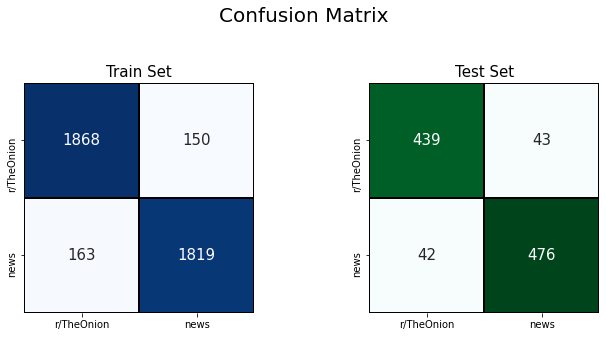

In [38]:
print(classification_report(y_test, y_pred))

# plot heatmap to see the confusion matrix in train and test sets respectively
fig ,ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle("Confusion Matrix", fontsize=20)
fig.tight_layout(pad = 3)

sns.heatmap(
    confusion_matrix(y_train, LogReg_GridSearch.predict(X_train_sc)),
    annot= True,
    square = True,
    linecolor= "Black",
    linewidths=1,
    ax=ax[0],
    fmt='g',
    cmap ='Blues',
    annot_kws={"size": 15},
    cbar=False

)
ax[0].set_title("Train Set", fontsize=15);
ax[0].set_xticklabels(['r/TheOnion','news'], fontsize=10)
ax[0].set_yticklabels(['r/TheOnion','news'], fontsize=10)


sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot= True,
    square = True,
    linecolor= "Black",
    linewidths=1,
    ax=ax[1],
    fmt='g',
    cmap ='BuGn',
    annot_kws={"size": 15},
    cbar=False
)
ax[1].set_title("Test Set", fontsize=15);
ax[1].set_xticklabels(['r/TheOnion','news'], fontsize=10)
ax[1].set_yticklabels(['r/TheOnion','news'], fontsize=10);


___

## 2b. Modeling - K-Nearest Neighbors (KNN)
- StandardScaler was shown to achieve higher score with KNN, hence we use StandardScaler.

In [13]:
X = df_combined.iloc[:,:-1]
y = df_combined.iloc[:,-1]

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=.2, random_state=24)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# instantiate KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_sc, y_train)
y_pred = knn.predict(X_test_sc)
print("KNN")
print(accuracy_score(y_train,knn.predict(X_train_sc)))

KNN
0.85725


#### GridSearchCV for hyperparameter tuning

In [14]:
knn = KNeighborsClassifier()
knn = GridSearchCV(estimator=knn, param_grid={'n_neighbors':[3,5,7,9],
                                        'algorithm':['ball_tree','kd_tree','auto']},
             verbose = 1, cv =5,return_train_score = False, n_jobs=-1)

knn.fit(X_train_sc,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'auto'],
                         'n_neighbors': [3, 5, 7, 9]},
             verbose=1)

In [15]:
df = pd.DataFrame(knn.cv_results_)
df = df[['param_algorithm','param_n_neighbors','mean_test_score']]
knn.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 3}

In [16]:
knn_GridSearch = KNeighborsClassifier(algorithm= 'ball_tree', n_neighbors= 5)
knn_GridSearch.fit(X_train_sc, y_train)
y_pred = knn_GridSearch.predict(X_test_sc)
print(knn_GridSearch.score(X_train_sc, y_train))
print(knn_GridSearch.score(X_test_sc, y_test))

0.81875
0.725


___

## 2c. Modeling - Naive Bayes
- StandardScaler cannot be used on Naive Bayes as it only accepts positive values. Hence we use MinMaxScaler here.

In [17]:
X = df_combined.iloc[:,:-1]
y = df_combined.iloc[:,-1]
# train test split
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=.2, random_state=24)
ss = MinMaxScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)
# instantiate model
nb = MultinomialNB()

nb.fit(X_train_sc, y_train)
y_pred = nb.predict(X_test_sc)

print("MNB")
print(accuracy_score(y_train,nb.predict(X_train_sc)))

MNB
0.70825


#### GridSearchCV for hyperparameter tuning

In [18]:
nb = MultinomialNB()
nb = GridSearchCV(estimator=nb, param_grid={'alpha':[0.5,0.7,1,1.2,1.5,2,3,4,5,7,9,10]},
             verbose = 1, cv =5,return_train_score = False, n_jobs=-1)

nb.fit(X_train_sc,y_train)
nb.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'alpha': 0.5}

In [19]:
nb_GridSearch = MultinomialNB(alpha=1)
nb_GridSearch.fit(X_train_sc, y_train)
y_pred = nb_GridSearch.predict(X_test_sc)
print(nb_GridSearch.score(X_train_sc, y_train))
print(nb_GridSearch.score(X_test_sc, y_test))

0.70825
0.685


___

# 3. Evaluation of results

After running through GridSearchCV we found that Logistic Regression works the best after hyperparameter tuning.

In [20]:
# highest impacting features 
x = pd.DataFrame(LogReg_GridSearch.coef_.T)
y = pd.DataFrame(X_train.columns)

coef = pd.concat((y,x),axis=1)
coef.columns=['features', 'coef']
coef.coef = coef.coef.map(lambda x : abs(x))
coef = coef.sort_values(by='coef' , ascending=False)

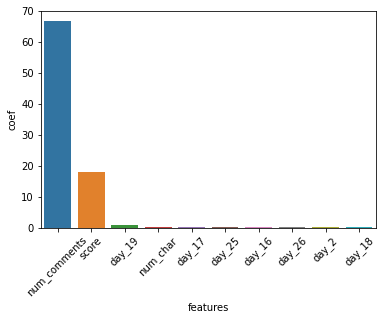

In [21]:
coef = coef[0:10]
sns.barplot(x='features', y='coef', data = coef)
plt.xticks(rotation = 45);

From the above, we can see that number of comments and scores are heavily affecting the model in terms of classifying fake or real news. Interestingly, the number of days also affect. However this could be due to limitations with the data taken from r/news. 